# Solving the 4-Coloring Problem using a Quantum Circuit Generator

In this paper, we solve the 4-Coloring problem using a quantum algorithm.  We go beyond the theory and implement this using Qiskit and run it on a quantum simulator, and so that it can be run on a future quantum computer with longer decoherence time. As the code gets rather long, to avoid making mistakes in quantum uncomputation, we introduce the SafeCircuit class, which when used properly, takes care of uncomputation.

We import qiskit:

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import BasicAer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, compile
from qiskit.tools.visualization import plot_histogram

We need to extend the n-Controlled Z gate provided in the qiskit tutorial at https://github.com/Qiskit/qiskit-tutorials to allow 4 controls. This requires the use of auxiliary qubits.

In [51]:
def n_controlled_Z(circuit, controls, target, aux2=None):
    """Implement a Z gate with multiple controls"""
    
    # considers nothing about the topology.
    if (len(controls) > 4):
        raise ValueError('The controlled Z with more than 4 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
    elif (len(controls) >= 3):
        if not len(aux2) >= 2: raise Exception("Need auxiliary qubits")
        
        if (len(controls) == 3):
            circuit.h(target)
            circuit.ccx(controls[0], controls[1], aux2[0])
            circuit.ccx(controls[2], aux2[0], target)
            circuit.ccx(controls[0], controls[1], aux2[0])
            circuit.h(target)
          
        else:
            raise Exception("This ncz gate is not implemented")


In [56]:
def inversion_about_average(circuit, f_in, n, aux2):
    """Apply inversion about the average step of Grover's algorithm."""
    # Hadamards everywhere
    for j in range(n):
        circuit.h(f_in[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1], aux2)
    for j in range(n):
        circuit.x(f_in[j])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h(f_in[j])
# -- end function

Now, let's write a oracle to 2-color a graph of length 3.  The full code for Grover's algorithm is in the last cell of this of this document; the function to run can be changed by changing `oracle_func`.

In [70]:
def color_works(circuit, f_in, f_out, aux, n):
    # see if you can two-color the straight graph of length 3
    
    circuit.cx(f_in[0], aux[0])
    circuit.cx(f_in[1], aux[0])
    
    circuit.cx(f_in[1], aux[1])
    circuit.cx(f_in[2], aux[1])
    
    circuit.ccx(aux[0], aux[1], f_out[0])
   
    # Uncompute
    circuit.cx(f_in[2], aux[1])
    circuit.cx(f_in[1], aux[1])
    
    circuit.cx(f_in[1], aux[0])
    circuit.cx(f_in[0], aux[0])

Here is the SafeCircuit.  We provide operations for combining multiple individual circuits.

In [52]:
import copy

class Operation():
    #self.op = None
    #self.dirty = None
    
    def __init__(self, op, dirty):
        #TODO add an ID for printing
        self.op = op
        self.dirty = dirty
    
    def __str__(self):
        return self.op[0]+"("+", ".join(repr(e) for e in self.op[1:])+")"+" (dirty)"*self.dirty
    
    def write(self, cir):
        func = self.op[0] # this might not work, might have to pass cir.func and then can drop cir as a parameter
        getattr(cir, func)(*self.op[1:])

class SafeCircuit():
    written = dict()
    
    #self.cir = None
    
    def __init__(self, cir):
        self.cir = cir
        self.l = []
        self.oplist = []
        SafeCircuit.written[self.cir.name] = False # todo some way to hash it
    
    def __str__(self):
        self.finalize()
        return "\n".join(str(e) for e in self.oplist)
    # could include something if we make sure dirty are not actually used again at any time in the future until they are reset?
    # this would work for final ones also, because they are never reset
     
    def add_op(self, *op, dirty=False): # advanced: isoutput should be set only on an output bit
        self.l.append(Operation(op, dirty))
        # we should be able to get away with only one level, 'dirty'.  Other levels should not be set as they would prevent uncomputation unless they are in the outermost circuit.  If they are computed in a loop, it is acceptable to measure them before the next one.
        
    def add_cir(self, subcir): # don't carry through dirty.  The dirty will be reverted as the others are finalized
        subops = subcir.finalize()
        for op in subops:
            op2 = copy.deepcopy(op)
            op2.dirty = False
            # do these actually need to be uncomputed at the end, or can they all be marked as dirty?
            # I think they all need to be to reverse the central one that is dirty, so this is right
            self.l.append(op2)
        
    def blind_concat(self, other):
        raise Exception("Why would you do this?")
        # self.l += copy.deepcopy(other.l)
    
    def __iter__(self):
        for i in range(len(self.oplist)):
            yield self.oplist[i]
    
    def finalize(self): # just builds the necessary list; you can do this more than once
        oplist = []
        
        for i in range(len(self.l)):
            op = self.l[i].op
            oplist.append(self.l[i])
        
        for i in range(len(self.l)-1, -1, -1):
            # dirty or not is ignored when executing individually
            if not self.l[i].dirty:
                op = self.l[i].op
                oplist.append(self.l[i])
        
        self.oplist = oplist
        return oplist
    
    def dowrite(self):
        for op in self.oplist:
            op.write(self.cir)
    
    def write(self):
        #TODO check if the self.cir is empty before writing
        
        if SafeCircuit.written[self.cir.name]:
            raise Exception("You have already written a SafeCircuit to this QuantumCircuit once; operations would not be safely uncomputed. If you want to run multiple circuits, use the add_cir method to add one to the other. Exiting")
        
        self.finalize()
        
        SafeCircuit.written[self.cir.name] = True
        self.dowrite()
        


We write various functions, working our way up to 4-coloring a graph.

In [54]:
def color2_works_safe_old(circuit, f_in, f_out, aux, n):
    # see if you can two-color the straight graph of length 4
    # make sure color 0 is vertex 0
    
    # check connection 0-1
    
    sc = SafeCircuit(circuit)
    sc.add_op('cx', f_in[0], aux[0])
    sc.add_op('cx', f_in[1], aux[0])
    
    
    inv2 = SafeCircuit(circuit)
    inv2.add_op('x', f_in[2])
    inv2.add_op('cx', f_in[2], aux[1], dirty=True)
    
    
    print("this is inv2: \n" + "\n".join(str(e) for e in inv2.l))
    
    sc.add_op('cx', f_in[1], aux[1])
    sc.add_cir(inv2)
    
    sc.add_op('ccx', aux[0], aux[1], f_out[0], dirty=True) # !
    
    print("Executing: \n" + "\n".join(str(e) for e in sc.oplist))
    
    sc.write()

In [55]:
def color2_works_safe(circuit, f_in, f_out, aux, n):
    # see if you can two-color the straight graph of length 4
    # make sure color 0 is vertex 0
    
    # check connection 0-1
    
    sc = SafeCircuit(circuit)
    sc.add_op('cx', f_in[0], aux[0])
    sc.add_op('cx', f_in[1], aux[0])
    
    sc.add_op('cx', f_in[1], aux[1])
    sc.add_op('cx', f_in[2], aux[1])
    #print("this is inv2: \n" + "\n".join(str(e) for e in inv2.l))
    
    sc.add_op('ccx', aux[0], aux[1], f_out[0], dirty=True) # !
    
    print("Executing: \n" + str(sc)) #"\n".join(str(e) for e in sc.oplist))
    
    sc.write()

In [57]:
def color2_works_safe_force0(circuit, f_in, f_out, aux, n):
    # see if you can two-color the straight graph of length 4
    # make sure color 0 is vertex 0
    
    # check connection 0-1
    
    sc = SafeCircuit(circuit)
    sc.add_op('cx', f_in[0], aux[0])
    sc.add_op('cx', f_in[1], aux[0])
    
    sc.add_op('cx', f_in[1], aux[1])
    sc.add_op('cx', f_in[2], aux[1])
    
    inv2 = SafeCircuit(circuit)
    inv2.add_op('x', f_in[2])
    inv2.add_op('cx', f_in[2], aux[2], dirty=True)
    sc.add_cir(inv2)
    
    #print("this is inv2: \n" + "\n".join(str(e) for e in inv2.l))
    
    sc.add_op('ccx', aux[0], aux[1], aux[3])
    sc.add_op('ccx', aux[3], aux[2], f_out[0], dirty=True) # !
    
    #print("Executing: \n" + str(sc)) #"\n".join(str(e) for e in sc.oplist))
    
    sc.write()

In [58]:
def color2_works_safe_forcenot1(circuit, f_in, f_out, aux, n):
    # see if you can two-color the straight graph of length 4
    # make sure color 0 is vertex 0
    
    # check connection 0-1
    
    sc = SafeCircuit(circuit)
    sc.add_op('cx', f_in[0], aux[0])
    sc.add_op('cx', f_in[1], aux[0])
    
    sc.add_op('cx', f_in[1], aux[1])
    sc.add_op('cx', f_in[2], aux[1])
    
    inv2 = SafeCircuit(circuit)
    inv2.add_op('cx', f_in[2], aux[2])
    inv2.add_op('x', aux[2], dirty=True)
    sc.add_cir(inv2)
    
    #print("this is inv2: \n" + "\n".join(str(e) for e in inv2.l))
    
    sc.add_op('ccx', aux[0], aux[1], aux[3])
    sc.add_op('ccx', aux[3], aux[2], f_out[0], dirty=True) # !
    
    #print("Executing: \n" + str(sc)) #"\n".join(str(e) for e in sc.oplist))
    
    sc.write()

In [53]:
def twocolor_sample(circuit, f_in, f_out, aux, n):
    # see if you can two-color the straight graph of length 4
    # make sure color 0 is vertex 0
    
    # check connection 0-1
    
    sc = SafeCircuit(circuit)
    
    
    s1 = SafeCircuit(circuit)
    
    s1.add_op('cx', f_in[0], aux[0])
    s1.add_op('cx', f_in[2], aux[0])
    s1.add_op('x', aux[0])
    
    s1.add_op('cx', f_in[1], aux[1])
    s1.add_op('cx', f_in[3], aux[1])
    s1.add_op('x', aux[1])
    
    s1.add_op('ccx', aux[0], aux[1], aux[8], dirty=True)
    s1.add_op('x', aux[8], dirty=True)
    
    sc.add_cir(s1) # now can we reuse 0 and 1?
    
    
    s2 = SafeCircuit(circuit)
    
    s2.add_op('cx', f_in[2], aux[0])
    s2.add_op('cx', f_in[4], aux[0])
    s2.add_op('x', aux[0])
    
    s2.add_op('cx', f_in[3], aux[1])
    s2.add_op('cx', f_in[5], aux[1])
    s2.add_op('x', aux[1])
    
    s2.add_op('ccx', aux[0], aux[1], aux[7], dirty=True)
    s2.add_op('x', aux[7], dirty=True)
    
    sc.add_cir(s2) # now can we reuse 0 and 1?
    
    
    sc.add_op('ccx', aux[8], aux[7], f_out[0], dirty=True)
    
    sc.write()
    

In [71]:

def color4_works_safe(circuit, f_in, f_out, aux, n):
    # see if you can four-color the straight graph of length 2 with some conditions
    
    # check connection 0-1
    
    #sc = SafeCircuit(circuit)
    
    
    s1 = SafeCircuit(circuit)
    
    s1.add_op('cx', f_in[0], aux[0])
    s1.add_op('cx', f_in[2], aux[0])
    s1.add_op('x', aux[0])
    
    s1.add_op('cx', f_in[1], aux[1])
    s1.add_op('cx', f_in[3], aux[1])
    s1.add_op('x', aux[1])
    
    s1.add_op('ccx', aux[0], aux[1], aux[8], dirty=True)
    s1.add_op('x', aux[8], dirty=True)
    
    # now can we reuse 0 and 1
    
    #curaux = 2
    ## simulate a fixed 1 connected to point 2 of the graph
    
    desired_colors=[3,0]
    
    for node,color in enumerate(desired_colors):
        curaux = 2+node
        print("curaux", curaux)
        assert 2 <= curaux < 7
    
        for term in range(4):
            if term != color: # and (node == 0 or term != desired_colors[node-1]): # we want to only allow it to be 1, so let's connect a bunch of stubs to it
                s3_i = SafeCircuit(circuit)
                bs = bin(term)[2:].zfill(2)
                for i in range(len(bs)):
                    print("node", node, "color", color, "term", term, "bs", bs, "bs[i]", bs[i])
                    if bs[i] == '0':  
                        s3_i.add_op('cx', f_in[2*node+i], aux[i])
                        s3_i.add_op('x', aux[i])
                    elif bs[i] == '1':
                        rev5into1 = SafeCircuit(circuit)
                        rev5into1.add_op('x', f_in[2*node+i])
                        rev5into1.add_op('cx', f_in[2*node+i], aux[i], dirty=True)
                        s3_i.add_cir(rev5into1)
                        #print("rev5into1",rev5into1)
                        s3_i.add_op('x', aux[i])

                    else:
                        raise Exception("Internal error converting to binary", bs, bs[i])
                    
                    #s3_i.add_op('x', aux[i])

                s3_i.add_op('ccx', aux[0], aux[1], aux[curaux], dirty=True)
                s3_i.add_op('x', aux[curaux], dirty=True)
                
                print("node", node, "color", color, "term", term)# "s3_i:\n", s3_i)
                s1.add_cir(s3_i)

    
    
    #finalcir1 = SafeCircuit(circuit)
    #finalcir1.add_op('ccx', aux[8], aux[7], aux[1])
    #finalcir1.add_op('ccx', aux[1], aux[2], aux[0])
    #finalcir1.add_op('ccx', aux[8], aux[7], aux[1])
    s1.add_op('ccx', aux[8], aux[2], aux[5])
    s1.add_op('ccx', aux[5], aux[3], f_out[0], dirty=True)
    #sc.add_cir(finalcir1)
    
    '''
    finalcir2 = SafeCircuit(circuit)
    finalcir2.add_op('ccx', aux[0], aux[3], aux[1])
    finalcir2.add_op('ccx', aux[1], aux[4], f_out[0], dirty=True)
    sc.add_cir(finalcir2)
    '''
    
    
    s1.write()
    
    
    
    '''
    circuit.cx(f_in[2], aux[2]) # f_in[2] should be 1, or 0 if x'd.  As if connected to another 0 node.
    
    
    circuit.cx(f_in[0], aux[4]) # f_in[0] should be 1, or 0 if x'd.
    '''
    
    '''
    circuit.ccx(aux[0], aux[1], aux[3])
    circuit.ccx(aux[3], aux[2], aux[5])
    
    circuit.ccx(aux[5], aux[4], f_out[0]) # !
    
    circuit.ccx(aux[3], aux[2], aux[5])
    circuit.ccx(aux[0], aux[1], aux[3])
    '''
    
    
    #sc.add_op('ccx', aux[0], aux[1], f_out[0], dirty=True) # !
    
    
    #print("Executing: \n" + "\n".join(str(e) for e in s1.oplist))
    
    
    '''
    circuit.cx(f_in[0], aux[4]) # f_in[0] should be 1, or 0 if x'd.
    
    circuit.cx(f_in[2], aux[2]) # f_in[2] should be 1, or 0 if x'd.
    '''
    
    
    #circuit.cx(f_in[2], aux[1])
    #circuit.cx(f_in[1], aux[1])
    
    
    #circuit.cx(f_in[1], aux[0])
    #circuit.cx(f_in[0], aux[0])
    

In [72]:
def color4_works_safe_force0(circuit, f_in, f_out, aux, n):
    # see if you can two-color the straight graph of length 4
    # make sure color 0 is vertex 0
    
    # check connection 0-1
    
    sc = SafeCircuit(circuit)
    
    
    s1 = SafeCircuit(circuit)
    
    s1.add_op('cx', f_in[0], aux[0])
    s1.add_op('cx', f_in[2], aux[0])
    s1.add_op('x', aux[0])
    
    s1.add_op('cx', f_in[1], aux[1])
    s1.add_op('cx', f_in[3], aux[1])
    s1.add_op('x', aux[1])
    
    s1.add_op('ccx', aux[0], aux[1], aux[8])
    s1.add_op('x', aux[8])
    
    s1.add_op('cx', f_in[0], aux[2])
    s1.add_op('cx', f_in[1], aux[3])
    
    finalcir1.add_op('ccx', aux[8], aux[2], aux[5])
    finalcir1.add_op('ccx', aux[5], aux[3], f_out[0], dirty=True)
    
    sc.add_cir(s1) # now can we reuse 0 and 1?

Here is the code for Grover's Algorithm, based on the Qiskit code.  To change the function, change `oracle_func` and change `T` to change the number of iterations of Grover's Algorithm.

circuit32
4 qubits
Performing 2 iterations of the Grover's Algorithm with <function color4_works_safe at 0x135C1E88> 50 times
curaux 2
node 0 color 3 term 0 bs 00 bs[i] 0
node 0 color 3 term 0 bs 00 bs[i] 0
node 0 color 3 term 0
node 0 color 3 term 1 bs 01 bs[i] 0
node 0 color 3 term 1 bs 01 bs[i] 1
node 0 color 3 term 1
node 0 color 3 term 2 bs 10 bs[i] 1
node 0 color 3 term 2 bs 10 bs[i] 0
node 0 color 3 term 2
curaux 3
node 1 color 0 term 1 bs 01 bs[i] 0
node 1 color 0 term 1 bs 01 bs[i] 1
node 1 color 0 term 1
node 1 color 0 term 2 bs 10 bs[i] 1
node 1 color 0 term 2 bs 10 bs[i] 0
node 1 color 0 term 2
node 1 color 0 term 3 bs 11 bs[i] 1
node 1 color 0 term 3 bs 11 bs[i] 1
node 1 color 0 term 3
curaux 2
node 0 color 3 term 0 bs 00 bs[i] 0
node 0 color 3 term 0 bs 00 bs[i] 0
node 0 color 3 term 0
node 0 color 3 term 1 bs 01 bs[i] 0
node 0 color 3 term 1 bs 01 bs[i] 1
node 0 color 3 term 1
node 0 color 3 term 2 bs 10 bs[i] 1
node 0 color 3 term 2 bs 10 bs[i] 0
node 0 color 3 term 2
c

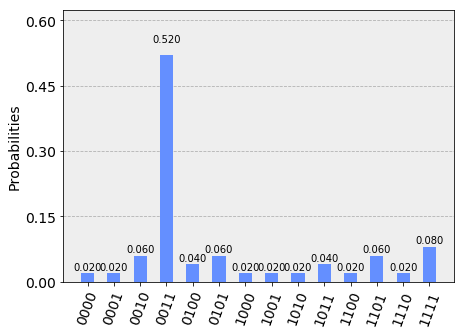

In [75]:
# Them

"""
Grover search implemented in Qiskit.

This module contains the code necessary to run Grover search on 3
qubits, both with a simulator and with a real quantum computing
device. This code is the companion for the paper
"An introduction to quantum computing, without the physics",
Giacomo Nannicini, https://arxiv.org/abs/1708.03684. 
"""

def input_state(circuit, f_in, f_out, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)
# -- end function

# Make a quantum program for the n-bit Grover search.


funcstonumqubits = {color4_works_safe: 4, color2_works_safe: 3}


oracle_func = color4_works_safe #color2_works_safe_force0 #color4_oneseg_safe # color_works
n = 3

if oracle_func in funcstonumqubits:
    n = funcstonumqubits[oracle_func]

# n = 4 # remove!

# Exactly-1 3-SAT formula to be satisfied, in conjunctive
# normal form. We represent literals with integers, positive or
# negative, to indicate a Boolean variable or its negation.
exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3], [1, 2, -3]]

# Define three quantum registers: 'f_in' is the search space (input
# to the function f), 'f_out' is bit used for the output of function
# f, aux are the auxiliary bits used by f to perform its
# computation.
f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(9) #len(exactly_1_3_sat_formula) + 1)
aux2 = QuantumRegister(2)

# Define classical register for algorithm result
ans = ClassicalRegister(n)



# Define quantum circuit with above registers
grover = QuantumCircuit()
print(grover.name)
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)
grover.add_register(aux2)
grover.add_register(ans)

input_state(grover, f_in, f_out, n)

NUMSHOTS = 50

import math
T = int(math.pi/4.0 * math.sqrt(2**n))
print(n, "qubits")
T = 2
print("Performing", T, "iterations of the Grover's Algorithm", "with", repr(oracle_func),NUMSHOTS, 'times')


for t in range(T):
    # Apply T full iterations
    #black_box_u_f(grover, f_in, f_out, aux, n, exactly_1_3_sat_formula)
    #example_is010_v0(grover, f_in, f_out, aux, n)
    #color4_works_safe(grover, f_in, f_out, aux, n)
    '''inversion_about_average(grover, f_in, n, aux2)
    oracle_func(grover, f_in, f_out, aux, n)
    '''
        
    oracle_func(grover, f_in, f_out, aux, n) 
    inversion_about_average(grover, f_in, n, aux2)


    
# Measure the output register in the computational basis
for j in range(n):
    grover.measure(f_in[j], ans[j])

# Execute circuit
backend = BasicAer.get_backend('qasm_simulator')
job = execute([grover], backend=backend, shots=NUMSHOTS)
result = job.result()

# Get counts and plot histogram
counts = result.get_counts(grover)
print(counts)
plot_histogram(counts)